In [1]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
import matplotlib.pyplot as plt
from einops import *

from model import MLPModel, MLPConfig, EigModel, SparseEigModel
from utils import define_scheduler_lambda


# Train Model

In [135]:
scheduler_epochs = [4, 6, 10]
config = MLPConfig(d_model = 300, 
                   n_layer = 2,
                    weight_decay = 0.5,
                    latent_noise = 0.33, 
                    input_noise = 0.33,
                    normalization = None,
                    epochs = sum(scheduler_epochs) + 50, 
                    scheduler_epochs = scheduler_epochs,
                    scheduler_min_lambda = 0.03,
                    scheduler_steps_per = 2,
                    )
model = MLPModel(config).to('mps')

In [84]:
model.fit()

Evaluation | Accuracy: 8.07 %, Loss: 2.3026
Epoch [1/70], Step [100/600], CE_loss: 2.2732, loss: 2.2732
Epoch [1/70], Step [200/600], CE_loss: 1.8459, loss: 1.8459
Epoch [1/70], Step [300/600], CE_loss: 1.5117, loss: 1.5117
Epoch [1/70], Step [400/600], CE_loss: 1.0672, loss: 1.0672
Epoch [1/70], Step [500/600], CE_loss: 1.1130, loss: 1.1130
Epoch [1/70], Step [600/600], CE_loss: 1.1464, loss: 1.1464
learning rate = 3e-05
Evaluation | Accuracy: 85.65 %, Loss: 0.8878
Epoch [2/70], Step [100/600], CE_loss: 0.9354, loss: 0.9354
Epoch [2/70], Step [200/600], CE_loss: 0.9400, loss: 0.9400
Epoch [2/70], Step [300/600], CE_loss: 0.7141, loss: 0.7141
Epoch [2/70], Step [400/600], CE_loss: 0.6910, loss: 0.6910
Epoch [2/70], Step [500/600], CE_loss: 0.8968, loss: 0.8968
Epoch [2/70], Step [600/600], CE_loss: 0.6513, loss: 0.6513
learning rate = 0.00017320508075688773
Evaluation | Accuracy: 88.63 %, Loss: 0.6307
Epoch [3/70], Step [100/600], CE_loss: 0.8679, loss: 0.8679
Epoch [3/70], Step [200/6

In [85]:
filename = 'mnist_l2_d300_input_noise.pt'
with open(filename, 'wb') as f:
    torch.save(model, f)

In [86]:
model.save_pretrained('saved_models/mnist_l2_d300_input_noise')

# Load Model

In [2]:
model = MLPModel.from_pretrained('saved_models/mnist_l2_d300_input_noise')

In [3]:
model.validation()

Evaluation | Accuracy: 98.74 %, Loss: 0.0607


(98.74, 0.060730554345919924)

# Sparse EigModel

In [14]:
sparse_eigmodel = SparseEigModel(model).to('mps')
config = sparse_eigmodel.config
config.L1_param = .01
config.epochs = 100
config.lr = 0.001
config.scheduler_epochs = [0, 100, 0]
config.scheduler_min_lambda = 0.03
config.scheduler_steps_per = 1

In [15]:
sparse_eigmodel.set_dataset()
sparse_eigmodel.validation()

Evaluation | Accuracy: 98.74 %, Loss: 0.0607


(98.74, 0.06073052446042084)

In [5]:
sparse_eigmodel.fit()

STAGE:2024-06-06 11:29:57 99544:67336973 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
[W CPUAllocator.cpp:235] Memory block of unknown size was allocated before the profiling started, profiler results will not include the deallocation event


Evaluation | Accuracy: 98.74 %, Loss: 0.0607
Epoch [1/100], Step [100/600], CE_loss: 0.0341, L1: 8.7358, L0: 704670.3125, loss: 0.1214


STAGE:2024-06-06 11:32:51 99544:67336973 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-06-06 11:32:51 99544:67336973 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


KeyboardInterrupt: 

# EigModel

In [ ]:
x_in = torch.randn(100, 10, 28, 54)
topk = 100000

shape = x_in.shape
x = x_in.reshape(shape[0], shape[1], -1) # [batch, class, eig]
topk = min(topk, x.shape[-1])
values, indices = torch.topk(x.abs(), topk, dim=-1, sorted=False)
y = torch.zeros_like(x)
y = y.scatter(-1, indices, x).reshape(shape)
y

tensor([[[[-5.0788e-02,  8.5604e-02,  1.3789e-03,  ...,  1.6140e+00,
            1.5148e+00,  9.4066e-02],
          [ 1.3883e+00,  1.3465e+00, -2.0490e-01,  ..., -1.8864e+00,
            1.4810e+00, -1.4876e-01],
          [ 6.2999e-01,  1.5777e+00, -1.0477e+00,  ...,  3.4320e+00,
            1.4238e+00, -1.4795e+00],
          ...,
          [ 6.4850e-02, -1.0238e-01,  9.4494e-01,  ...,  3.6061e-01,
           -2.5401e-01,  3.3656e-01],
          [-1.6221e+00,  1.8498e-01,  1.9064e-01,  ..., -6.0732e-01,
            3.7124e-01, -1.1240e-01],
          [ 3.1008e-01, -1.2885e+00,  8.9986e-01,  ..., -1.7115e-01,
            2.3250e-02,  1.4740e+00]],

         [[-1.0383e+00, -9.1276e-01, -6.7550e-01,  ..., -4.8075e-01,
           -3.6399e-01,  3.0998e-01],
          [-1.4370e+00, -6.9716e-01,  1.4595e+00,  ..., -1.6439e+00,
           -3.1028e-01, -8.2877e-01],
          [ 1.0839e+00, -5.9206e-01, -1.0550e+00,  ..., -1.4885e+00,
            5.6290e-01,  7.4722e-01],
          ...,
     

In [ ]:
plt.plot(x.cpu().flatten(), y.cpu)

In [14]:
y[y.abs() >  0].shape

torch.Size([100000])

In [59]:
eigmodel = EigModel(model).to('mps')
eigmodel.config.topk =  1000000
eigmodel.device

device(type='mps', index=0)

In [60]:
eigmodel.validation()

Evaluation | Accuracy: 20.25 %, Loss: 2.8536


(20.25, 2.8535824632644653)

In [61]:
eigmodel.set_dataset()
inputs, labels = eigmodel.transform_inputs(*next(iter(eigmodel.train_loader)))
embed = eigmodel.Embed(inputs)
y = eigmodel.layers[0].forward(embed)

In [62]:
y[y.abs() > 0].shape

: 

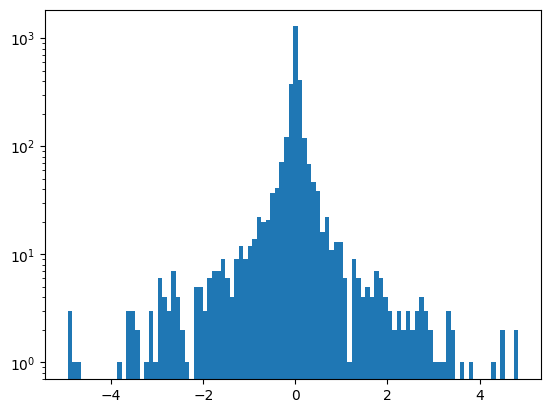

In [54]:
x = einsum(eigmodel.layers[0].eigvecs, embed, '... eig d_model, batch d_model -> batch ... eig')
x = x**2
x = einsum(eigmodel.eff_eigvals.to("mps"), x, '... eig, batch ... eig -> batch ...')

plt.hist(x[2].flatten().cpu(), bins=100)
plt.yscale('log')

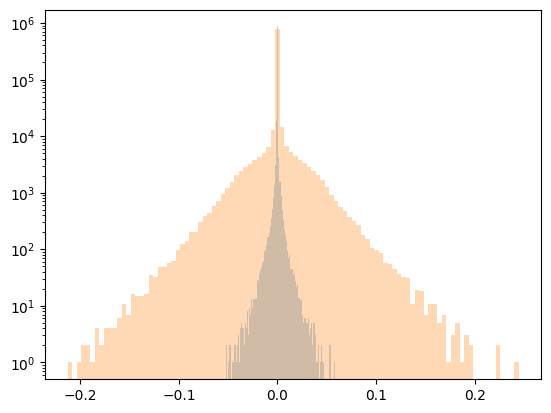

In [49]:
eff_eigvals = eigmodel.eff_eigvals
plt.hist(eff_eigvals.flatten(), bins=100, alpha=0.3)
plt.hist(eigmodel.layers[0].eigvals.flatten().cpu(), bins = 100, alpha=0.3)
plt.yscale('log')

In [38]:
eff_eigvals[eff_eigvals.abs() > 0.001].shape

torch.Size([17270])

(299, 296)
tensor(0.0261)


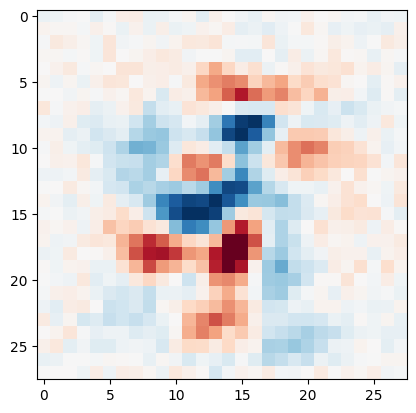

In [41]:
idx = 3

root_idx = (9,)
eigvals = eff_eigvals[root_idx]
topk = eigvals.flatten().topk(100)
topk_idxs= torch.unravel_index(topk.indices, eigvals.shape)
eigvec_idxs = tuple(topk_idxs[i][idx].item() for i in range(len(eigvals.shape)))
print(eigvec_idxs)
print(eigvals[eigvec_idxs])
eigvec = eigmodel.layers[0].eigvecs[root_idx + eigvec_idxs]
eigvec_emb = (eigvec @ eigmodel.Embed.weight).detach().cpu()

plt.imshow(eigvec_emb.reshape(28,28), cmap = 'RdBu', vmin=-0.25, vmax=0.25)

In [ ]:
(5,) + (5,)

(5, 5)